##### Importing modules:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

##### Defining the Neural Network object:

In [2]:
"""
Possible improvements for more specific/variable control of networks:

    >Implement deterministic dropout. (Maybe possible to selectively boost learning within the network?)
    >Implement layer-wise batch normalization
    >Implement Input layer batch normalization and node transformations.
    >Implement batch-wise gradient descent(SGD) to relieve my fingers from the pain of training all 42000 examples one by one manually.
    >Implement function to shuffle and split data into mini-batches, then return an iterator through each batch.
"""
class NN(object):
    # len(layer_sizes) == layers + 1 ; (Since, input layer is also included.)
    def __init__(model, layers, layer_sizes, activations, loss_func, deriv_loss, method='standard',AdaM_opt=False,dropout=False):
        def assign_func(name:str):
            match name:
                case 'ReLU':
                    # return (lambda x: x*(x>0), lambda x: 1*(x>0))
                    return (lambda x: x*(x>0), lambda y: 1*(y>0))
                case 'Leaky_ReLU':
                    # return (lambda x: x*(x>0) + 0.5*x*(x<0), lambda x: 1*(x>0) + 0.5*(x<0))
                    return (lambda x: x*(x>0) + 0.5*x*(x<0), lambda y: 1*(y>0) + 0.5*(y<0))
                case 'Sigmoid':
                    # return (lambda x: np.where(x<0,np.exp(x)/(1+np.exp(x)),1/(1+np.exp(-x))), lambda x: (1/(1+np.exp(-x)))*(1 - 1/(1+np.exp(-x)))) # Numerically unstable
                    return (lambda x: np.where(x<0,np.exp(x)/(1+np.exp(x)),1/(1+np.exp(-x))), lambda y: y*(1-y))
                case 'tanh':
                    # return (lambda x: np.tanh(x),lambda x: 1 - (np.tanh(x))**2)
                    return (lambda x: np.tanh(x),lambda y: 1 - (y**2))
                case 'my_transform': # With the unbound nature of 'ReLU' and the smooth nature of 'tanh'.
                    # return(lambda x:np.log(np.abs((2*(x>0)-1)+x)), lambda x: 1 / np.abs((2*(x>0)-1)+x))
                    return(lambda x:np.log(np.abs((2*(x>0)-1)+x)), lambda y: 1/np.exp(np.abs(y)))
                case _:
                    # return (lambda x: x, lambda x: 1)
                    return (lambda x: x, lambda y: 1)
        
        def set_hyper_params(model):
            # alpha = int(input("Enter the learning rate : "))
            model.alpha = 0.01
            # lmbd = int(input("Regularization rate (0 to nullify): "))
            model.lmbd = 0
            model.deriv_reglr = {"L2":lambda x: x, "L1":lambda x: 1}

            if(model.node_type=='batch_norm'):
                model.BN_decay = 0.9 # The exponentially weighted average decay factor of batch 'means' and 'stddevs'
            
            if(model.isAdaM):
                # b1 = int(input("Enter the first moment decay factor : "))
                b1 = 0.9
                # b2 = int(input("Enter the second moment decay factor : "))
                b2 = 0.999
                eps = 1.0e-8 # Numerical stability constant
                model.AdaM_params = {"b1":b1, "b2":b2, "eps":eps}
  
        model.cache = dict()
        
        model.back_trials = 0
        model.frwrd_trials = 0

        model.loss = loss_func
        model.deriv_loss = deriv_loss

        model.layers = np.asarray(layer_sizes,dtype=np.dtype("int64"))
        model.node_type = method
        model.isAdaM = AdaM_opt
        
        # This does not ensure that ONLY 80% of nodes will be dropped out. Maybe more, maybe less.
        model.dropout_probs = np.ones(shape=(layers+1, 1)) - (dropout)*np.random.random(size=(layers+1, 1)) / 5 # Not less than 80%
        model.dropout_probs[layers, 0] = model.dropout_probs[0, 0] = 1 # No dropout in input and output layers.
        
        # Declare and Define the model:
        # 'object' dtype as the different layers are of different dimensions.
        model.W_layers = np.empty((layers+1,),dtype='object')
        model.layer_activs = np.empty((layers+1,),dtype='object')
        model.layer_activ_derivs = np.empty((layers+1,),dtype='object')

        if(method=='standard'):
            model.b_layers = np.empty((layers+1,),dtype='object')
        elif(method=='batch_norm'):
            # Expected input feature distribution parameters of layers.
            model.E_stddev_layers = np.empty((layers+1,),dtype='object')
            model.E_mean_layers = np.empty((layers+1,),dtype='object')
            # Preferred/Trained ouput distribution parameters of layers.
            model.sig_layers = np.empty((layers+1,),dtype='object')
            model.mu_layers = np.empty((layers+1,),dtype='object')

        if(AdaM_opt):
            model.mnt_layers = np.empty((layers+1,),dtype='object')
            model.mnt_sqr_layers = np.empty((layers+1,),dtype='object')
        
        # Initialize the model:
        for l in range(1,layers+1):
            model.W_layers[l] = np.random.rand(layer_sizes[l],layer_sizes[l-1])
            model.layer_activs[l], model.layer_activ_derivs[l] = assign_func(activations[l-1])
            
            if(AdaM_opt):
                mnt_W = np.zeros((layer_sizes[l],layer_sizes[l-1]))
                mnt_sqr_W = np.zeros((layer_sizes[l],layer_sizes[l-1]))
            
            if(method=='standard'):
                model.b_layers[l] = np.zeros(shape=(layer_sizes[l], 1))
                
                if(AdaM_opt):
                    mnt_b = np.zeros(shape=(layer_sizes[l], 1))
                    mnt_sqr_b = np.zeros(shape=(layer_sizes[l], 1))

                    model.mnt_layers[l] = (mnt_W, mnt_b)
                    model.mnt_sqr_layers[l] = (mnt_sqr_W, mnt_sqr_b)
            
            elif(method=='batch_norm'):
                model.sig_layers[l] = np.ones(shape=(layer_sizes[l], 1))
                model.mu_layers[l] = np.zeros(shape=(layer_sizes[l], 1))

                # Default assumed 'normal' values. Justification? Numerical invariance for batch_size = 1.
                model.E_stddev_layers[l] = np.ones(shape=(layer_sizes[l], 1))
                model.E_mean_layers[l] = np.zeros(shape=(layer_sizes[l], 1))
                
                if(AdaM_opt):
                    mnt_sig = np.zeros(shape=(layer_sizes[l], 1))
                    mnt_sqr_sig = np.zeros(shape=(layer_sizes[l], 1))
                    mnt_mu = np.zeros(shape=(layer_sizes[l], 1))
                    mnt_sqr_mu = np.zeros(shape=(layer_sizes[l], 1))

                    model.mnt_layers[l] = (mnt_W, mnt_sig, mnt_mu)
                    model.mnt_sqr_layers[l] = (mnt_sqr_W, mnt_sqr_sig, mnt_sqr_mu)
        
        # Set model hyperparameters:
        set_hyper_params(model)


##### Batch-Normalization Routines:

In [3]:
# Batch Normalization:
"""
Given, an ndarray of features, normalizes them by Z-transform and returns the results.
NOTE: Normalizes the features along axis-1 (i.e. the columns).

Z-transform is a 1-to-1 map of any variable 'x' with an arbitrary distribution in examples:

    Z-transform(x) = (x - mean) / (stddev) ; 
        
        mean - is the average value of variable 'x' in its distribution.
        stddev - is the standard deviation of variable 'x' in its distribution.
"""
def batch_normalize(model:NN,l):

    dpt_mask = model.cache[f"mask{l}"]
    feature_batches = model.cache[f"X{l}"]

    # Shapes: (layer_size, 1)
    batch_m = model.cache[f"batch_m{l}"] = np.mean(feature_batches,axis=1,keepdims=True)
    batch_std = model.cache[f"batch_std{l}"] = np.std(feature_batches,axis=1,keepdims=True)

    # Broadcast and transform.
    model.cache[f"Z{l}"] = (feature_batches - batch_m) / np.where(batch_std==0,np.inf,batch_std) # To prevent division by 0.
    model.cache[f"Z_hat{l}"] = (model.sig_layers[l]*model.cache[f"Z{l}"] + model.mu_layers[l]) * dpt_mask

    # These exponentially weighted parameters are a form of "moving"/"sliding" metrics 
    # which are calculated over a "window" of observations of any vast distribution. 
    # In our case, this "window" is a specific batch of example data.
    # These exponentially weighted metrics, approximate the true values.
    model.E_mean_layers[l][dpt_mask[:,0]] = (model.BN_decay*model.E_mean_layers[l] + (1-model.BN_decay)*batch_m)[dpt_mask[:,0]] # Update expected means of layer.
    model.E_stddev_layers[l][dpt_mask[:,0]] = (model.BN_decay*model.E_stddev_layers[l] + (1-model.BN_decay)*batch_std)[dpt_mask[:,0]] # Update expected stddevs of layer.
    
    # NOTE: Bias Correction factor to be applied after, if required. NUMERICALLY UNSTABLE WHEN LARGE NUMBER OF TRIALS OCCURED.
    model.E_stddev_layers[l][dpt_mask[:,0]] = (model.E_stddev_layers[l]/(1-model.BN_decay**model.frwrd_trials))[dpt_mask[:,0]]
    model.E_mean_layers[l][dpt_mask[:,0]] = (model.E_mean_layers[l]/(1-model.BN_decay**model.frwrd_trials))[dpt_mask[:,0]]


# Normalises a feature values of a network layer, with *predetremined* 'means' and 'stddevs'. 
def normalize(model:NN,l):
    # Shape: (layer_size,1)
    model.cache[f"Z{l}"] = ((model.cache[f"X{l}"] - model.E_mean_layers[l]) / np.where(model.E_stddev_layers[l]==0,np.inf,model.E_stddev_layers[l])) # To prevent division by 0.
    model.cache[f"Z_hat{l}"] = (model.sig_layers[l]*model.cache[f"Z{l}"] + model.mu_layers[l]) * model.cache[f"mask{l}"]


##### Forward pass routines:

In [4]:
# Forward propagation
"""
Takes the 'outputs' of a former layer of network and processes them through the current layer.
It first applies the weights(W) and biases(b) of the current layer onto the 'outputs' of former layer, 
then transforms these linear combinations by applying the activation function, to give final result.
"""
def forward_prop_layer(model:NN,l): 
    dpt_mask = model.cache[f"mask{l}"]
    
    if(model.node_type=='batch_norm'):
        model.cache[f"X{l}"] = np.matmul(model.W_layers[l], model.cache[f"A{l-1}"]) * dpt_mask # Shape: (layer_size, batch_size)
        
        if(model.cache[f"X{l}"].shape[1]!=1):
            batch_normalize(model,l)
        else:
            normalize(model,l)
        
        model.cache[f"A{l}"] = model.layer_activs[l](model.cache[f"Z_hat{l}"]) * dpt_mask
    
    if(model.node_type=='standard'):
        model.cache[f"X{l}"] = (model.W_layers[l].dot(model.cache[f"A{l-1}"]) + model.b_layers[l]) * dpt_mask # Shape: (layer_size, batch_size)
        model.cache[f"A{l}"] = model.layer_activs[l](model.cache[f"X{l}"]) * dpt_mask


##### Backward pass routines:

In [5]:
# Backward propagation and Gradient Descent
# Question: To divide by 'batch_size' or to not?
"""
Updates the weights and biases of a layer from the output loss-gradients of the layers after, 
and returns the output loss-gradients of the layers before as well as the 
output loss gradients of weights and biases of the current layer.
"""
def back_prop_layer(model:NN,l):
    batch_size = model.cache[f"X{l}"].shape[1]
    model.cache[f"dA{l}"] = model.cache[f"dA{l}"] * model.cache[f"mask{l}"]
    
    back_prop_nodes(model,l)

    # The partial derivative of total loss w.r.t ouputs of the former layer.
    model.cache[f"dA{l-1}"] = model.W_layers[l].T.dot(model.cache[f"dX{l}"]) # Shape: (prev_layer_size, batch_size)

    model.cache[f"dW{l}"] = model.cache[f"dX{l}"].dot(model.cache[f"A{l-1}"].T) / batch_size # Shape: (layer_size, prev_layer_size)
    
    if(model.lmbd!=0):
        d_reg_W = model.deriv_reglr["L2"](model.W_layers[l]) / batch_size # Shape: (layer_size, prev_layer_size)
        model.cache[f"dW{l}"] = model.cache[f"dW{l}"] + (model.lmbd * d_reg_W * model.cache[f"mask{l}"])
        
        if(model.node_type=='batch_norm'):
            d_sig_W = model.deriv_reglr["L2"](model.sig_layers[l]) / batch_size # Shape: (layer_size, prev_layer_size)
            model.cache[f"dSig{l}"] = model.cache[f"dSig{l}"] + (model.lmbd * d_sig_W * model.cache[f"mask{l}"])

    if(model.node_type=='standard'):
        model.cache[f"dB{l}"] = np.sum(model.cache[f"dX{l}"],axis=1,keepdims=True) / batch_size # Shape: (layer_size,1)

    grad_descent(model,l)

def back_prop_nodes(model:NN,l):
    batch_size = model.cache[f"X{l}"].shape[1]

    if(model.node_type=='batch_norm'):
        # Shapes: (layer_size,batch_size)
        # model.cache[f"dZ_hat{l}"] = model.layer_activ_derivs[l](model.cache[f"Z_hat{l}"]) * model.cache[f"dA{l}"] # w.r.t input.
        model.cache[f"dZ_hat{l}"] = model.layer_activ_derivs[l](model.cache[f"A{l}"]) * model.cache[f"dA{l}"] # w.r.t output
        model.cache[f"dZ{l}"] = model.cache[f"dZ_hat{l}"] * model.sig_layers[l]
        
        # Shapes: (layer_size, 1)
        model.cache[f"dMu{l}"] = np.sum(model.cache[f"dZ_hat{l}"],axis=1,keepdims=True) / batch_size
        model.cache[f"dSig{l}"] = np.sum(model.cache[f"dZ_hat{l}"] * model.cache[f"Z{l}"],axis=1,keepdims=True) / batch_size

        # Shape: (layer_size, batch_size)
        model.cache[f"dX{l}"] = ((1/batch_size) * model.sig_layers[l] / np.where(model.cache[f"batch_std{l}"]!=0,model.cache[f"batch_std{l}"],np.inf)) * (-model.cache[f"dSig{l}"]*model.cache[f"Z{l}"] + (batch_size)*model.cache[f"dZ_hat{l}"] - model.cache[f"dMu{l}"])
    
    if(model.node_type=='standard'):
        # Shape: (layer_size, batch_size)
        # model.cache[f"dX{l}"] = model.layer_activ_derivs[l](model.cache[f"X{l}"]) * model.cache[f"dA{l}"] # w.r.t input
        model.cache[f"dX{l}"] = model.layer_activ_derivs[l](model.cache[f"A{l}"]) * model.cache[f"dA{l}"] # w.r.t output

# Question: Should the residual moments for AdaM optimized gradient descent update parameters for dropped out nodes in network?
# In following implementation, the moments start to decay if nodes are dropped out, and keep updating the model parameters regardless of drop-out.
def grad_descent(model:NN,l):
    if(model.node_type=='standard'): # Model parameters: 'W' and 'b'.
        if(model.isAdaM):
            # Unpacking the first and second moment terms of 'W' and 'b'
            m_W, m_b = model.mnt_layers[l]
            m_sqr_W, m_sqr_b = model.mnt_sqr_layers[l]

            b1 = model.AdaM_params["b1"]
            b2 = model.AdaM_params["b2"]
            eps = model.AdaM_params["eps"]
            
            trials = model.back_trials 
            
            # Update Exponentially weighted averages
            m_W = b1*m_W + (1-b1)*model.cache[f"dW{l}"]
            m_sqr_W = b2*m_sqr_W + (1-b2)*(model.cache[f"dW{l}"]**2)

            m_b = b1*m_b + (1-b1)*model.cache[f"dB{l}"]
            m_sqr_b = b2*m_sqr_b + (1-b2)*(model.cache[f"dB{l}"]**2)

            # Does this work?
            model.mnt_layers[l], model.mnt_sqr_layers[l] = (m_W, m_b), (m_sqr_W, m_sqr_b)
            
            # Bias correction and update formula:
            model.cache[f"dW{l}"] = (m_W / (1-b1**trials)) / (np.sqrt(m_sqr_W/(1-b2**trials)) + eps)
            model.cache[f"dB{l}"] = (m_b / (1-b1**trials)) / (np.sqrt(m_sqr_b/(1-b2**trials)) + eps)

        model.W_layers[l] = model.W_layers[l] - model.alpha * model.cache[f"dW{l}"]
        model.b_layers[l] = model.b_layers[l] - model.alpha * model.cache[f"dB{l}"]
    
    if(model.node_type=='batch_norm'):
        if(model.isAdaM):
            m_W, m_sig, m_mu = model.mnt_layers[l]
            m_sqr_W, m_sqr_sig, m_sqr_mu = model.mnt_sqr_layers[l]

            # Unpacking hyper parameters.
            b1 = model.AdaM_params["b1"]
            b2 = model.AdaM_params["b2"]
            eps = model.AdaM_params["eps"]

            trials = model.back_trials
            
            # Update Exponentially weighted averages
            m_W = b1*m_W + (1-b1)*model.cache[f"dW{l}"]
            m_sqr_W = b2*m_sqr_W + (1-b2)*(model.cache[f"dW{l}"]**2)

            m_sig = b1*m_sig + (1-b1)*model.cache[f"dSig{l}"]
            m_sqr_sig = b2*m_sqr_sig + (1-b2)*(model.cache[f"dSig{l}"]**2)

            m_mu = b1*m_mu + (1-b1)*model.cache[f"dMu{l}"]
            m_sqr_mu = b2*m_sqr_mu + (1-b2)*(model.cache[f"dMu{l}"]**2)

            # Does this work?
            model.mnt_layers[l], model.mnt_sqr_layers[l] = (m_W, m_sig, m_mu), (m_sqr_W, m_sqr_sig, m_sqr_mu)

            # Bias correction and update formula:
            model.cache[f"dW{l}"] = (m_W / (1-b1**trials)) / (np.sqrt(m_sqr_W/(1-b2**trials)) + eps)
            model.cache[f"dSig{l}"] = (m_sig / (1-b1**trials)) / (np.sqrt(m_sqr_sig/(1-b2**trials)) + eps)
            model.cache[f"dMu{l}"] = (m_mu / (1-b1**trials)) / (np.sqrt(m_sqr_mu/(1-b2**trials)) + eps) 

        model.W_layers[l] = model.W_layers[l] - model.alpha * model.cache[f"dW{l}"]
        model.sig_layers[l] = model.sig_layers[l] - model.alpha * model.cache[f"dSig{l}"]
        model.mu_layers[l] = model.mu_layers[l] - model.alpha * model.cache[f"dMu{l}"]


##### Training and Inference routines:

In [6]:
# Training routine
def training_cycle(model:NN, X, Y):
    
    layers = model.layers.size - 1

    # Q: Dropout, Batch Normalize, Transform?
    model.cache[f"mask{0}"] = (np.random.random(size=(model.layers[0], 1)) < model.dropout_probs[0, 0])
    model.cache[f"A{0}"] = X * model.cache[f"mask{0}"]

    model.frwrd_trials += 1
    # Forward propagation through network.
    for l in range(1,layers+1):
        model.cache[f"mask{l}"] = (np.random.random(size=(model.layers[l], 1)) < model.dropout_probs[l, 0])
        forward_prop_layer(model,l)

    # Loss calculations:
    Y_hat = model.cache[f"A{layers}"]
    total_loss = (1/X.shape[1]) * np.sum(model.loss(Y,Y_hat),axis=1)
    
    model.cache[f"dA{layers}"] = model.deriv_loss(Y,Y_hat)
    
    model.back_trials += 1
    # Back propagation through network.
    for l in range(layers,0,-1):
        back_prop_layer(model,l)

    return total_loss

# Inference routine
def model_predict(model:NN, X):

    layers = model.layers.size - 1

    model.frwrd_trials += 1
    model.cache[f"A{0}"] = X
    # Forward propagation through network.
    for l in range(1,layers+1):
        model.cache[f"mask{l}"] = (np.random.random(size=(model.layers[l], 1)) < 1)
        forward_prop_layer(model,l)

    return model.cache[f"A{layers}"]


##### Various loss functions and their derivatives:

In [7]:
def softmax_transform(z):
    # For numerical stability
    z = z - np.max(z,axis=0,keepdims=True)

    exp_transform = np.exp(z)
    return exp_transform / np.sum(exp_transform,axis=0)

# It is a measure of accuracy: Higher means more accurate.
def softmax_loss(y,z):
    # y_hat = softmax_transform(z)
    # return np.sum(-(y*np.log(y_hat)),axis=0,keepdims=True)
    return np.sum((np.argmax(y,axis=0,keepdims=True) == np.argmax(softmax_transform(z),axis=0,keepdims=True)),axis=0,keepdims=True)

def softmax_loss_deriv(y,z):
    # -(y/y_hat) is the partial derivative of loss w.r.t 'softmax' output.
    
    # **This is the partial derivative of loss w.r.t 'softmax' input.
    # **Under the assumption**: For each of the labels(y) in data, there is one class which is '1' and all others are '0'.(i.e. 1-Hot Encoded Labels)  
    return (softmax_transform(z) - y)

# Another function whose derivative is completely defined by its output! Such functions seem to appear more often than I would expect.
def softmax_deriv(y_hat): # 'y_hat' has shape: (output_classes, batch_size)
    y_hat = y_hat.T

    # The (output_classes, output_classes) partial derivative matrix is symmetric for each example.
    derivs = -np.matmul(np.reshape(y_hat,(y_hat.shape[0], y_hat.shape[1], 1)), np.reshape(y_hat,(y_hat.shape[0], 1, y_hat.shape[1]))) 
    derivs = derivs + np.identity(derivs.shape[1])*(y_hat)

    # A 3-D grid of shape: (batch_size, output_classes, output_classes, )
    # Index (i,j,k) represents the partial derivative of 's-j' w.r.t. 'z-k' for the i'th example.
    # where, Z is the input vector to 'Softmax' function, and S is the output vector.
    return derivs


In [8]:
def mse_loss(y,y_hat):
    return 1/y.shape[0]*np.sum((y_hat-y)**2,axis=0,keepdims=True)

def mse_loss_deriv(y,y_hat):
    return 2 * (y_hat - y) / y.shape[0]

In [9]:
def log_loss(y,y_hat):
    return -np.sum(y*np.log(y_hat)-(1-y)*np.log(1-y_hat),axis=0,keepdims=True)
def log_loss_deriv(y,y_hat):
    return (1-y)/(1-y_hat) - y/y_hat

##### Learning the XOR gate:

In [10]:
# Data and the plotting function:
X_xor = np.asarray([[0,0],[0,1],[1,0],[1,1]]).T
Y_xor = np.asarray([[0],[1],[1],[0]]).T

def plot_decisions(model):
    points = []
    for x in np.linspace(0, 1, 20):
        for y in np.linspace(0, 1, 20):
            z = model_predict(model, [[x], [y]])
            points.append([x, y, z[0,0]])

    points = np.array(points)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=points[:, 2], cmap="winter")
    plt.show()

Trial 0: [2.2793644]
Trial 200: [0.28310292]
Trial 400: [0.23974522]
Trial 600: [0.22471992]
Trial 800: [0.21314436]
Trial 1000: [0.19897969]
Trial 1200: [0.18505764]
Trial 1400: [0.17402673]
Trial 1600: [0.16201726]
Trial 1800: [0.14912937]
Trial 2000: [0.13581173]
[[0.43253345 0.59423079 0.7052382  0.32279087]]


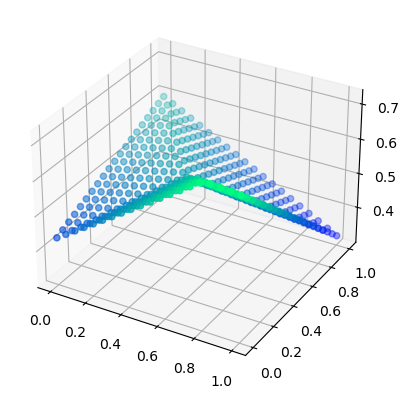

In [12]:
# Sharp activation:
model_XOR_sharp = NN(2,[2, 3, 1],["Leaky_ReLU", "Leaky_ReLU", ],mse_loss,mse_loss_deriv,'standard',False,False)

for trial in range(2001):
    loss = training_cycle(model_XOR_sharp,X_xor,Y_xor)
    if(trial%200==0):
        print(f"Trial {trial}:",loss)

print(model_predict(model_XOR_sharp,X_xor))

plot_decisions(model_XOR_sharp)

Trial 0: [0.24927009]
Trial 200: [0.23066236]
Trial 400: [0.21439723]
Trial 600: [0.19380308]
Trial 800: [0.17455453]
Trial 1000: [0.15573039]
Trial 1200: [0.13704986]
Trial 1400: [0.11925759]
Trial 1600: [0.10287189]
Trial 1800: [0.08809952]
Trial 2000: [0.07500517]
[[0.12769168 0.67874606 0.6741515  0.27219336]]


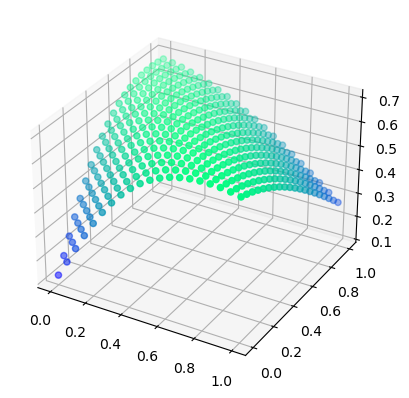

In [14]:
# Smooth activation:
model_XOR_smooth = NN(2,[2, 3, 1],["tanh", "tanh", ],mse_loss,mse_loss_deriv,'standard',False,False)

for trial in range(2001):
    loss = training_cycle(model_XOR_smooth,X_xor,Y_xor)
    if(trial%200==0):
        print(f"Trial {trial}:",loss)

print(model_predict(model_XOR_smooth,X_xor))

plot_decisions(model_XOR_smooth)

Trial 0: [0.41596083]
Trial 200: [0.12289327]
Trial 400: [0.00701694]
Trial 600: [6.8159549e-05]
Trial 800: [1.40400997e-07]
Trial 1000: [5.98432951e-11]
Trial 1200: [3.79594228e-15]
Trial 1400: [2.02494143e-20]
Trial 1600: [3.42248536e-27]
Trial 1800: [1.15494167e-29]
Trial 2000: [3.87034882e-30]
[[-8.88178420e-16  1.00000000e+00  1.00000000e+00 -1.11022302e-15]]


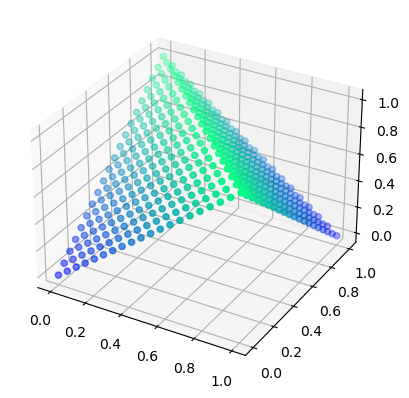

In [27]:
# AdaM optimized gradient descent( using sharp activation):
model_XOR_AdaM = NN(2,[2, 3, 1],["Leaky_ReLU", "Leaky_ReLU", ],mse_loss,mse_loss_deriv,'standard',True,False)

for trial in range(2001):
    loss = training_cycle(model_XOR_AdaM,X_xor,Y_xor)
    if(trial%200==0):
        print(f"Trial {trial}:",loss)

print(model_predict(model_XOR_AdaM,X_xor))

plot_decisions(model_XOR_AdaM)

##### Processing the MNIST Digit Classification Data:

In [70]:
# Data to train and compare models on: MNIST Decimal Digits
path = "./train.csv"

data = pd.read_csv(path)
data = data.iloc[np.random.permutation(data.shape[0]),:] # Shuffle the examples.

examples = data.shape[0]
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
34690,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31940,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11066,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8921,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36586,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
# Checking classes:
classes = data.loc[:,"label"].unique() 
print(classes)
output_dims = classes.size

[8 0 5 4 1 3 6 2 9 7]


In [72]:
# Extracting label and input ndarrays
y = data["label"].values
X = data.drop(columns=["label"]).values
input_dims = X.shape[1]

In [73]:
X = X.T # Shape: (layer_size, batch_size)

# 1-Hot Encoding the labels and transposing to required shape:
label_encoding = np.identity(output_dims)
encoder = lambda x: label_encoding[x]
y = encoder(y)
y = y.T # Shape: (layer_size, batch_size)

##### The 2 Layer Logistic Model:

In [74]:
model_A = NN(2,[input_dims, input_dims//5, output_dims],["Sigmoid", "Sigmoid", ],mse_loss,mse_loss_deriv,'batch_norm',True,True)

In [ ]:
"""
The model and its training journey:

    model_A = NN(2,[input_dims, input_dims//5, output_dims],["Sigmoid", "Sigmoid", ],mse_loss,mse_loss_deriv,'batch_norm',True,True)

Started with MSE loss, then shifted to softmax loss then finally settled with logistic loss.

Initially trained with Large dropout at high learning rate with mini-batches with MSE.

Once saturated, shifted to log loss training with lower learning rates with no dropout.

Continued training till saturated log loss.

Then started to train on specific batches with high loss thershold(~0.105) while adjusting alpha, total_trials for each batch, and also the sample_ratios intuitively.

    Usually the larger the sample_ratio, the lesser the total_trials dedicated to train it.

    Counterintuitively, during this last phase of training, the sum of weights and biases, kept changing alot while still improving accuracy score, 
    even though the training was done at exponentially lower learning rates. Maybe the space is very sharp and ragged, so the model was unable to traverse 
    it well earlier. One of the factors that caused this is the capabilites of Adaptive Moment Gradient Descent.

Reached 95% accuracy.
"""

In [684]:
# np.random.seed(694201337)
model_A.loss = log_loss
model_A.deriv_loss = log_loss_deriv
# model_A.dropout_probs[1, 0] = 1

# To prevent overflow
model_A.frwrd_trials = 1000
model_A.back_trials = 1000

model_A.alpha = 0.00001

sample_ratio = 0.02
sample_qnt = int(sample_ratio * examples)
mini_batches = 100


for _ in range(mini_batches):
    # Split, Shuffling and Division:
    # split_ratio = 0.06
    # split_point = int(split_ratio * examples)
    # shuffle = np.random.permutation(examples)
    # X = X[:,shuffle]
    # y = y[:,shuffle]
    # X_train, y_train = X[:,:split_point], y[:,:split_point]
    # X_test, y_test = X[:,split_point:], y[:,split_point:]

    # Sampling:
    sample_indices = np.random.choice(examples,sample_qnt,replace=False)
    X_train, y_train = X[:,sample_indices], y[:,sample_indices]

    total_trials = 21 # Depending on batch size. Higher batch size can be trained for longer and vice versa.

    train_loss_curve_A = np.empty((total_trials,),)
    # test_loss_curve_A = np.empty((total_trials,),)

    for trial in range(total_trials):
        if((1/X_train.shape[1]) * np.sum(model_A.loss(y_train,model_predict(model_A,X_train)),axis=1)<0.15):
            break

        train_loss_curve_A[trial] = training_cycle(model_A,X=X_train,Y=y_train)

        # Y_preds = model_predict(model_A,X_test)
        # test_loss_curve_A[trial] = 1/(y_test.shape[1]) * np.sum(softmax_loss(y_test,Y_preds),axis=1)

        if((trial)%5==0):
            print("Trial number:",trial)
            print("The total training accuracy: ",train_loss_curve_A[trial])
            # print("The total test accuracy: ",test_loss_curve_A[trial])
            print("---------------------------------------------------------------------------------------------------")


Trial number: 0
The total training accuracy:  0.09353821938869916
---------------------------------------------------------------------------------------------------
Trial number: 5
The total training accuracy:  0.09354064132932087
---------------------------------------------------------------------------------------------------
Trial number: 10
The total training accuracy:  0.09353813491475019
---------------------------------------------------------------------------------------------------
Trial number: 15
The total training accuracy:  0.09353274761328755
---------------------------------------------------------------------------------------------------
Trial number: 20
The total training accuracy:  0.09352567627652177
---------------------------------------------------------------------------------------------------
Trial number: 0
The total training accuracy:  0.06558796449404034
---------------------------------------------------------------------------------------------------
T

In [384]:
plt.plot(train_loss_curve_A)

In [685]:
for l in range(1,model_A.layers.size):
    print("Sum of weights:",np.sum(model_A.W_layers[l]))
    print("Sum of normalized scale:",np.sum(model_A.sig_layers[l]))
    print("Sum of normalized shifts:",np.sum(model_A.mu_layers[l]))

print("Number of steps taken backward:",model_A.back_trials)
print("Number of steps taken forward:",model_A.frwrd_trials)

Sum of weights: -21439.560009823683
Sum of normalized scale: -65.11692655385038
Sum of normalized shifts: 1998.2733881908837
Sum of weights: 2845.9991943487057
Sum of normalized scale: -19.89937623961698
Sum of normalized shifts: -73.43802004488033
Number of steps taken backward: 3100
Number of steps taken forward: 5200


In [686]:
y_pred = model_predict(model_A,X)
y_pred = (y_pred == np.max(y_pred,axis=0)) * 1.0

In [687]:
decode_labels = np.arange(10).reshape((10,1))
labels = np.max(y*decode_labels,axis=0)
predicted_labels = np.max(y_pred*decode_labels,axis=0)

print("Total examples:",labels.shape[0])
print("Incorrectly predicted examples",np.sum(labels != predicted_labels))
print("Incorrectly predicted",np.sum(labels != predicted_labels)/labels.shape[0]*100,"%")

Total examples: 42000
Incorrectly predicted examples 2057
Incorrectly predicted 4.897619047619048 %


In [691]:
random_example = np.random.randint(0,examples)
print("Reference answer:",y[:,[random_example]].T)
print("Model's answer:",y_pred[:,[random_example]].T)

Reference answer: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Model's answer: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [692]:
path = "./95_model_"
for l in range(1,model_A.layers.size):
    np.savetxt(path+f"W_{l}.txt",model_A.W_layers[l])
    np.savetxt(path+f"sig_{l}.txt",model_A.sig_layers[l])
    np.savetxt(path+f"mu_{l}.txt",model_A.mu_layers[l])
    np.savetxt(path+f"stddev_{l}.txt",model_A.E_stddev_layers[l])
    np.savetxt(path+f"mean_{l}.txt",model_A.E_mean_layers[l])
